# Comparing runtimes of different stop detection algorithms on toy datasets

Here we compare the runtimes of four different stop detection algorithms: Lachesis, grid-based, temporal DBSCAN, and HDBSCAN.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Imports
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import box
import pandas as pd
import numpy as np
from nomad.stop_detection.viz import plot_stops_barcode, plot_pings, plot_stops, plot_time_barcode
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.filters as filters 
import nomad.stop_detection.postprocessing as post
import time
from tqdm import tqdm

# Load data
import nomad.data as data_folder
from pathlib import Path
data_dir = Path(data_folder.__file__).parent
city = gpd.read_parquet(data_dir / 'garden-city-buildings-mercator.parquet')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters=('date','==', '2024-01-01'), traj_cols=tc)

# Lachesis (sequential stop detection)
start_time = time.time()
stops = LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)
execution_time_lachesis = time.time() - start_time
print(f"Lachesis execution time: {execution_time_lachesis} seconds")

# Density based stop detection (Temporal DBSCAN)
start_time = time.time()
user_data_tadb = traj.assign(cluster=DBSCAN.ta_dbscan_labels(traj, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
clustering_time_tadbscan = time.time() - start_time
start_time_post = time.time()
cluster_labels_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)
execution_time_tadbscan = time.time() - start_time
post_time_tadbscan = time.time() - start_time_post
print(f"TA-DBSCAN execution time: {execution_time_tadbscan} seconds")
print(f"TA-DBSCAN clustering time: {clustering_time_tadbscan} seconds")
print(f"TA-DBSCAN post-processing time: {post_time_tadbscan} seconds")

# Grid-based
start_time = time.time()
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, traj_cols=tc, data_crs='EPSG:3857')
stops_gb = GRID_BASED.grid_based(traj, time_thresh=240, complete_output=True, traj_cols=tc, location_id='h3_cell')
execution_time_grid = time.time() - start_time
print(f"Grid-Based execution time: {execution_time_grid} seconds")

# HDBSCAN
start_time = time.time()
user_data_hdb = traj.assign(cluster=HDBSCAN.hdbscan_labels(traj, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc))
clustering_time_hdbscan = time.time() - start_time
start_time_post = time.time()
cluster_labels_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)    
execution_time_hdbscan = time.time() - start_time
post_time_hdbscan = time.time() - start_time_post
print(f"HDBSCAN execution time: {execution_time_hdbscan} seconds")
print(f"HDBSCAN clustering time: {clustering_time_hdbscan} seconds")
print(f"HDBSCAN post-processing time: {post_time_hdbscan} seconds")

Lachesis execution time: 0.01671910285949707 seconds
TA-DBSCAN execution time: 0.015048027038574219 seconds
TA-DBSCAN clustering time: 0.0 seconds
TA-DBSCAN post-processing time: 0.015048027038574219 seconds
Grid-Based execution time: 0.01604151725769043 seconds
HDBSCAN execution time: 0.24063372611999512 seconds
HDBSCAN clustering time: 0.24063372611999512 seconds
HDBSCAN post-processing time: 0.0 seconds


## Summary of Single-User Performance

### Lachesis

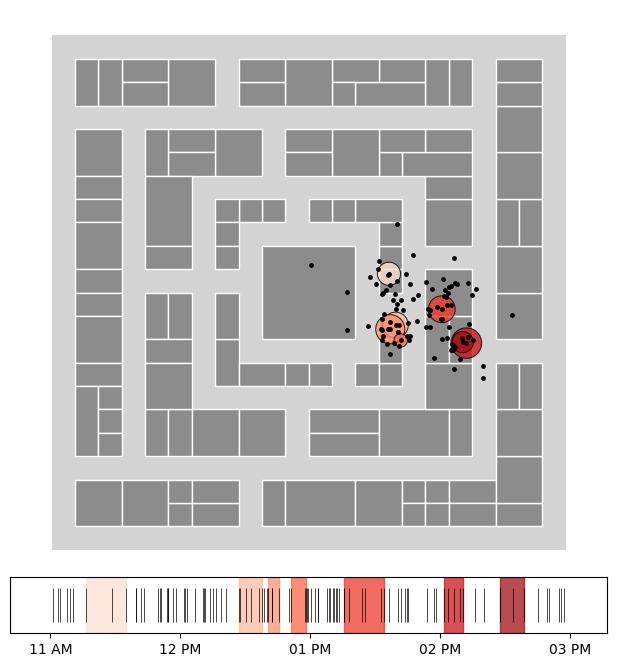

In [2]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

gpd.GeoDataFrame(geometry=[outer_box], crs='EPSG:3857').plot(ax=ax_map, color='#d3d3d3')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#8c8c8c')

plot_stops(stops, ax=ax_map, cmap='Reds')
plot_pings(traj, ax=ax_map, s=6, point_color='black', cmap='twilight', traj_cols=tc)
ax_map.set_axis_off()

plot_time_barcode(traj[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops, ax=ax_barcode, cmap='Reds', set_xlim=False, timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()

In [3]:
print("Summary of Single-User Performance")
print(f"Lachesis execution time: {execution_time_lachesis} seconds")
print(f"TA-DBSCAN execution time: {execution_time_tadbscan} seconds")
print(f"Grid-Based execution time: {execution_time_grid} seconds")
print(f"HDBSCAN execution time: {execution_time_hdbscan} seconds")

Summary of Single-User Performance
Lachesis execution time: 0.01671910285949707 seconds
TA-DBSCAN execution time: 0.015048027038574219 seconds
Grid-Based execution time: 0.01604151725769043 seconds
HDBSCAN execution time: 0.24063372611999512 seconds


In [4]:
print("Runtime Disaggregation")
print(f"Lachesis clustering time: {execution_time_lachesis} seconds")
print("--------------------------------")
print(f"TA-DBSCAN clustering time: {clustering_time_tadbscan} seconds")
print(f"TA-DBSCAN post-processing time: {post_time_tadbscan} seconds")
print("--------------------------------")
print(f"Grid-Based clustering time: {execution_time_grid} seconds")
print("--------------------------------")
print(f"HDBSCAN clustering time: {clustering_time_hdbscan} seconds")
print(f"HDBSCAN post-processing time: {post_time_hdbscan} seconds")

Runtime Disaggregation
Lachesis clustering time: 0.01671910285949707 seconds
--------------------------------
TA-DBSCAN clustering time: 0.0 seconds
TA-DBSCAN post-processing time: 0.015048027038574219 seconds
--------------------------------
Grid-Based clustering time: 0.01604151725769043 seconds
--------------------------------
HDBSCAN clustering time: 0.24063372611999512 seconds
HDBSCAN post-processing time: 0.0 seconds


## Pings vs Runtime

In [5]:
traj = loader.sample_from_file(filepath_root, format='parquet', traj_cols=tc, seed=10)

# H3 cells for grid_based stop detection method
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, traj_cols=tc, data_crs='EPSG:3857')
pings_per_user = traj['gc_identifier'].value_counts()

In [6]:
# Approximately 5 minutes for 40 users
results = []
for user, n_pings in tqdm(pings_per_user.items(), total=len(pings_per_user)):
    user_data = traj.query("gc_identifier == @user")

    # For location based
    start_time = time.time()
    stops_gb = GRID_BASED.grid_based(user_data, time_thresh=240, complete_output=True, traj_cols=tc, location_id='h3_cell')
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'grid_based', 'execution_time':execution_time, 'n_pings':n_pings})]
    
    # For Lachesis
    start_time = time.time()
    stops_lac = LACHESIS.lachesis(user_data, delta_roam=30, dt_max=240, complete_output=True, traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'lachesis', 'execution_time':execution_time, 'n_pings':n_pings})]

    # For TADbscan
    start_time = time.time()
    user_data_tadb = user_data.assign(cluster=DBSCAN.ta_dbscan_labels(user_data, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
    # - post-processing
    stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'tadbscan', 'execution_time':execution_time, 'n_pings':n_pings})]

    # For HDBSCAN
    start_time = time.time()
    user_data_hdb = user_data.assign(cluster=HDBSCAN.hdbscan_labels(user_data, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc))
    # - post-processing
    stops_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)    
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'hdbscan', 'execution_time':execution_time, 'n_pings':n_pings})]

results = pd.DataFrame(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:24<00:00,  1.50it/s]


 75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00,  6.61it/s]

100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]

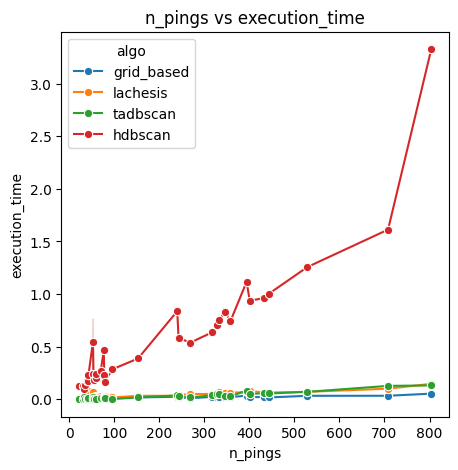

In [7]:
algos = ['grid_based', 'lachesis', 'tadbscan', 'hdbscan']
palette = dict(zip(algos, sns.color_palette(n_colors=len(algos))))

fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(data=results, marker='o', x='n_pings', y='execution_time', hue='algo', ax=ax)
ax.set_title('n_pings vs execution_time')
plt.show()